In [22]:
!git clone https://github.com/Antonomaz/Corpus.git 2> nul || cd Corpus && git pull

Already up to date.


In [23]:
from bs4 import BeautifulSoup
from pprint import pprint
from glob import glob
import json
from numpy import mean, std, amax, amin
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from collections import Counter
from pprint import pprint
import xmltodict
import contextlib


In [24]:
with open("LGERM.json", encoding="utf-8") as f:
    LGERM = json.load(f)
mots_LGERM = set(LGERM)

path = "Corpus/Mazarinades/*/*.xml"

files = glob(path)

print(len(files))

3065


In [25]:
def ttr(chaine):
    chaine = chaine.split()
    return len([word for word in chaine if word in mots_LGERM])/len(chaine)

def tok_voc_ratio(str):
    if not str:
        return
    lstr = str.split()
    return len(set(lstr))/len(lstr)

def compte_hapax(str):
    ct = Counter(str)
    return len([val for val in ct.values() if val == 1])

def eval_sub_type(str_):
    if str_ == "no":
        return False
    elif str_ == "yes":
        return True
    else:
        return str_


In [26]:

dict_stats = {}



for i, file in enumerate(tqdm(files)):
    with open(file, encoding="utf-8") as f:
        txt = f.read()


    dict_ = xmltodict.parse(txt)
    dict_ = dict_["TEI"]["teiHeader"]
    header = dict_["profileDesc"]["textClass"]["keywords"]["term"]
    header = [{header["@type"] : header["#text"] if "#text" in header else eval_sub_type(header["@subtype"]) if "@subtype" in header else None} for header in header]

    dict_header = {}
    for dicts in header:
        for k, v in dicts.items():
            if k not in dict_header:
                dict_header[k] = []
            dict_header[k].append(v)

    dict_header = {k : v if len(v) > 1 else v[0] for k, v in dict_header.items()}

    with contextlib.suppress(KeyError):
        creation = dict_["profileDesc"]["settingDesc"]["setting"]["date"]
        if creation is None:
            dict_header["creation"] = "00-00-0000"
        else:
            dict_header["creation"] = creation["@when"] if "@when" in creation else creation["#text"]

    dict_header["change"] = dict_["revisionDesc"]["change"]

    titre = dict_["fileDesc"]["titleStmt"]["title"]
    titre = [e for e in titre if e["@type"] == "main"][0]["#text"]
    dict_header["titre"] = titre if isinstance(titre, str) else " ".join(titre)

    dict_header["dates"] = dict_["fileDesc"]["publicationStmt"]["date"]



    tei_head = re.search(r"<teiHeader>.*?</teiHeader>", txt, re.DOTALL).group()

    soup = BeautifulSoup(tei_head, "html.parser")

    elts = {
        e.tag: e.text
        for e in soup.find_all()
    }


    txt = re.split(r"(?:<pb .*?>)", txt)[1:]
    txt = [re.split(r"\n|<lb/>|<l>", line) for line in txt]
    txt = [[re.sub(r"<.*?>|  |\t", "", line) for line in page] for page in txt]
    txt = [[line for line in page if line.strip()] for page in txt]
    txt = [page for page in txt if page]

    pages = [' '.join(line for line in page) for page in txt]

    plain = ' '.join(mot for page in txt for line in page for mot in line)

    if not txt:
        print(f"Empty file: {file}, {i = }")
        continue

    dict_stats[file] = {
        "pages": len(txt),
        "lines": sum(len(page) for page in txt),
        "words": sum(len(line.split()) for page in txt for line in page),
        "chars": sum(len(line) for page in txt for line in page),
        "ttr": ttr(plain),
        "tok_voc_ratio": tok_voc_ratio(plain),
        "hapax": compte_hapax(plain),
        "hapax_ratio": compte_hapax(plain)/len(plain.split()),
        "ttrs": [ttr(page) for page in pages],
        "header": dict_header,
    }


  0%|          | 0/3065 [00:00<?, ?it/s]

Empty file: Corpus/Mazarinades\1201-1300\Moreau1240_GALL.xml, i = 298


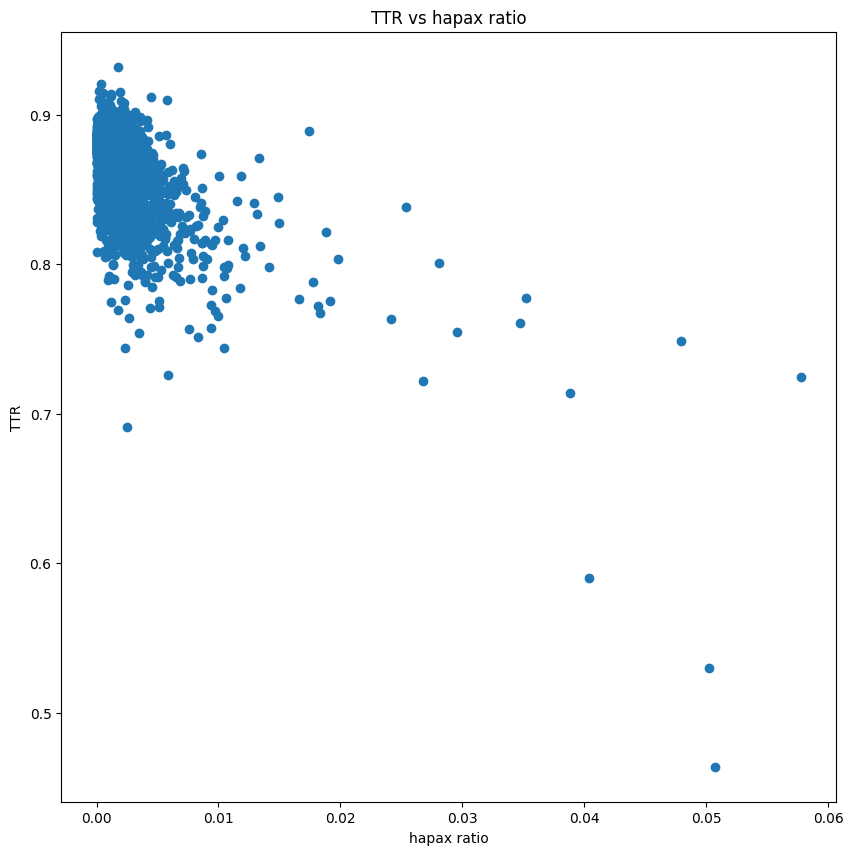

In [27]:
tup = [(val["hapax_ratio"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs hapax ratio")
plt.xlabel("hapax ratio")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))

plt.show()

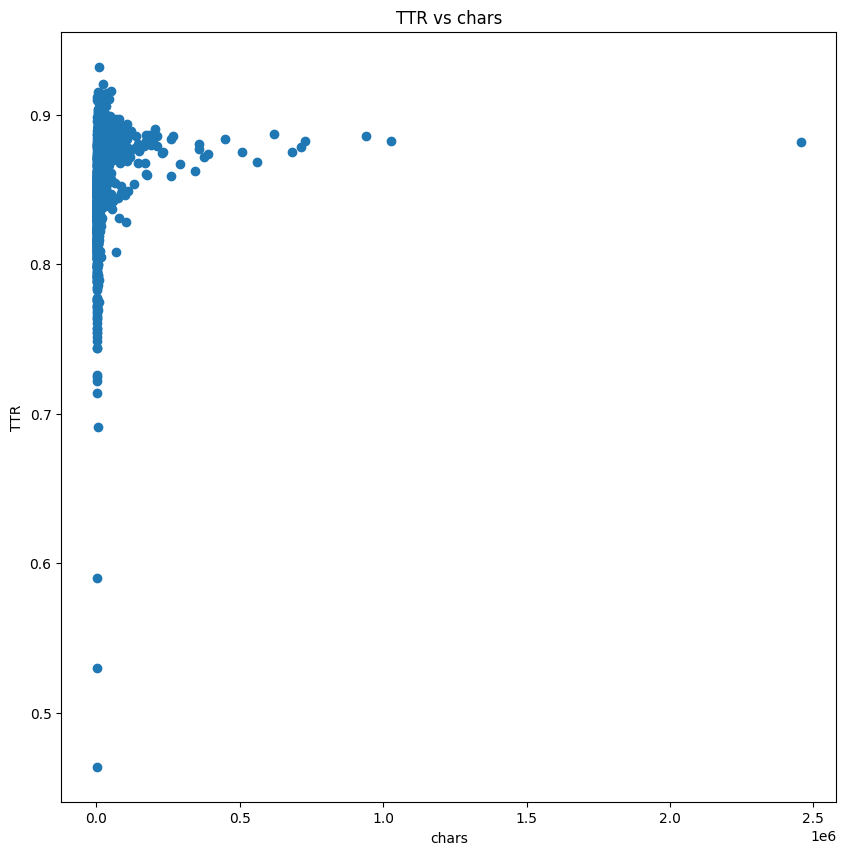

In [28]:
tup = [(val["chars"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs chars")
plt.xlabel("chars")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))


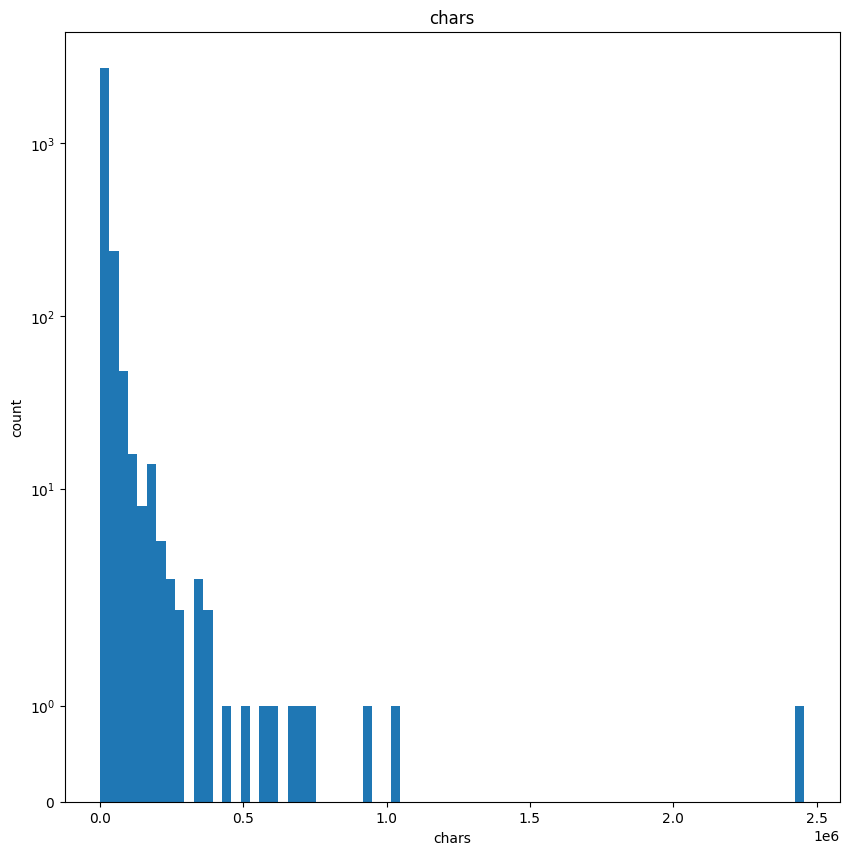

In [29]:
x = [v["chars"] for v in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("chars")
plt.xlabel("chars")
plt.ylabel("count")
plt.xscale('linear')
plt.yscale('symlog', linscale=1)
plt.hist(x, bins=75)

plt.show()

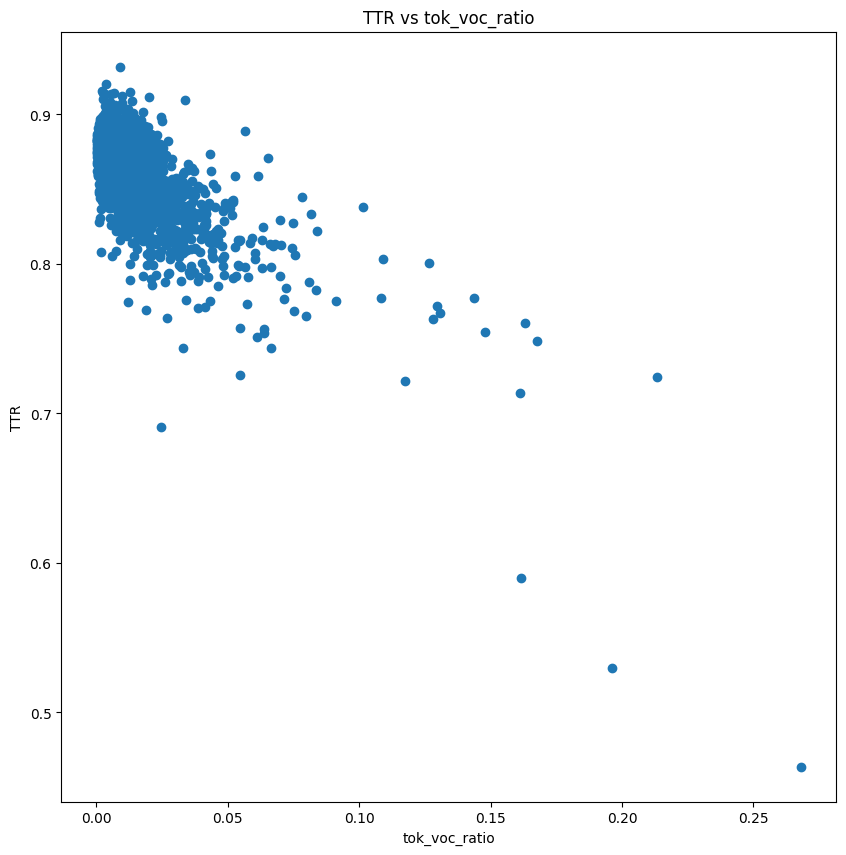

In [30]:
tup = [(val["tok_voc_ratio"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs tok_voc_ratio")
plt.xlabel("tok_voc_ratio")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))

plt.show()

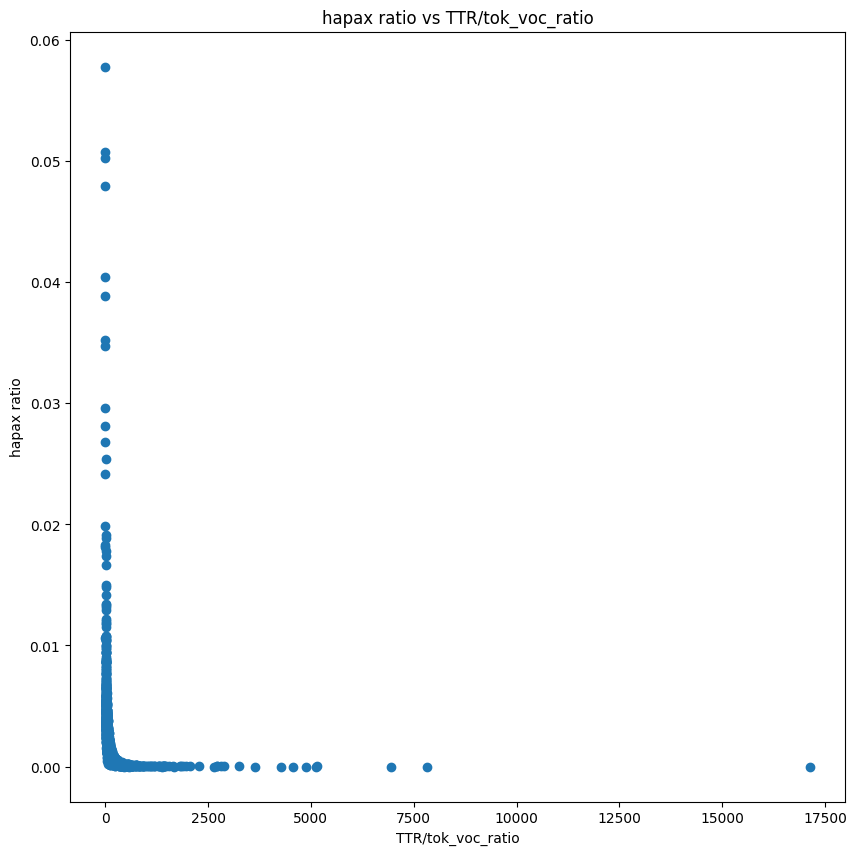

In [31]:
tup = [(val["ttr"]/ val["tok_voc_ratio"], val["hapax_ratio"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))

plt.title("hapax ratio vs TTR/tok_voc_ratio")

plt.xlabel("TTR/tok_voc_ratio")
plt.ylabel("hapax ratio")

plt.scatter(*zip(*tup))

plt.show()


In [32]:
tup = [(txt, val["ttr"]/ val["tok_voc_ratio"]) for txt, val in dict_stats.items()]

tup = sorted(tup, key=lambda x: x[1], reverse=True)

for txt, val in tup[:10]:
    print(f"{val:.3f} {txt}")

17127.000 Corpus/Mazarinades\3001-3100\Moreau3037_MAZ.xml
7831.827 Corpus/Mazarinades\1701-1800\Moreau1769_GBOOKS.xml
6951.598 Corpus/Mazarinades\1701-1800\Moreau1741_GBOOKS.xml
5145.057 Corpus/Mazarinades\3701-3800\Moreau3728_GBOOKS.xml
5128.894 Corpus/Mazarinades\1701-1800\Moreau1762_GBOOKS.xml
4886.760 Corpus/Mazarinades\1601-1700\Moreau1643_GBOOKS.xml
4568.578 Corpus/Mazarinades\1701-1800\Moreau1743_GBOOKS.xml
4267.656 Corpus/Mazarinades\3001-3100\Moreau3039_MAZ.xml
3631.760 Corpus/Mazarinades\3001-3100\Moreau3097_GBOOKS.xml
3241.644 Corpus/Mazarinades\2501-2600\Moreau2537_GBOOKS.xml


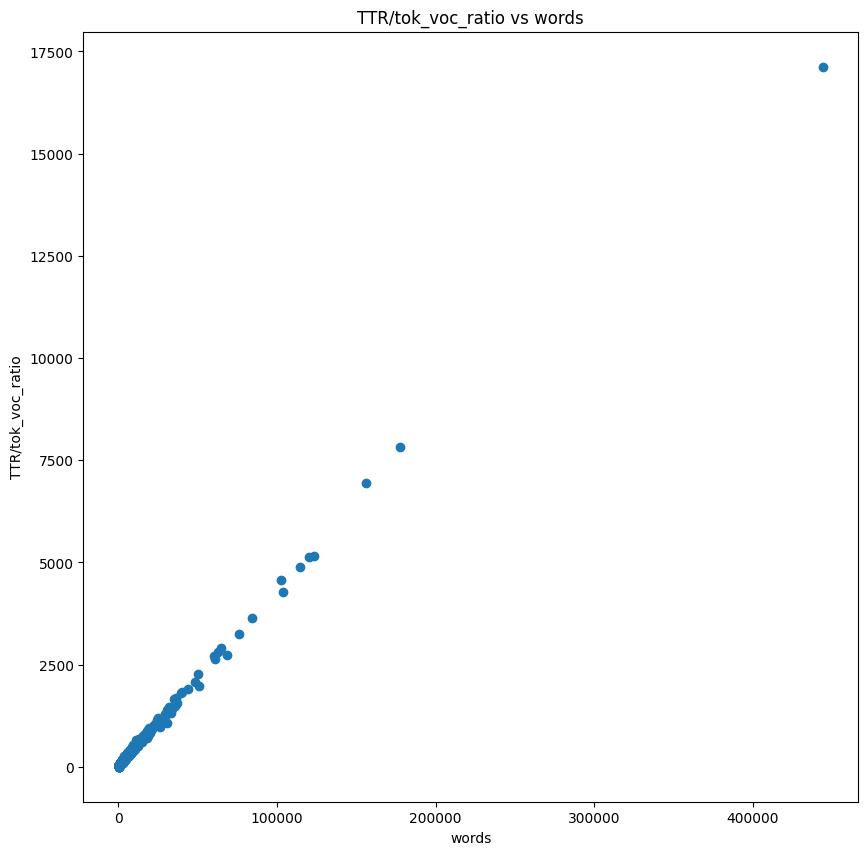

In [33]:
tup = [(val["words"], val["ttr"]/ val["tok_voc_ratio"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))

plt.title("TTR/tok_voc_ratio vs words")

plt.xlabel("words")
plt.ylabel("TTR/tok_voc_ratio")

plt.scatter(*zip(*tup))

plt.show()

In [40]:
x = [val["header"]["change"]["@status"] if isinstance(val["header"]["change"], dict) else val["header"]["change"][0]["@status"] for val in dict_stats.values()]
len(x)/ len([e for e in x if e == "corrected"])

1.0

In [48]:
for txt, val in dict_stats.items():
    pprint(val["header"])
    break

{'change': {'@status': 'corrected', '@when': '2022-09-06', '@who': 'AB'},
 'creation': '1650-01-18',
 'dates': [{'#text': '16 février 2021',
            '@type': 'file_creation',
            '@when': '2021-02-16'},
           {'#text': '23 avril 2021',
            '@type': 'correction',
            '@when': '2021-04-23'}],
 'form': 'vers',
 'genre': ['poésie', 'burlesque', 'satirique'],
 'handwritten_note': False,
 'illustration': False,
 'subject': 'Conti, Armand de Bourbon, prince de, 1629-1666',
 'table_of_content': False,
 'titre': "L'apologie de l'autruche en vers burlesques."}


In [47]:
val["tok_voc_ratio"]

0.01675

In [52]:
type_

['vers', 'prose']

vers: 0.018
prose: 0.013
('vers', 'prose'): 0.010
('prose', 'manifeste'): 0.005
('prose', 'récit'): 0.015


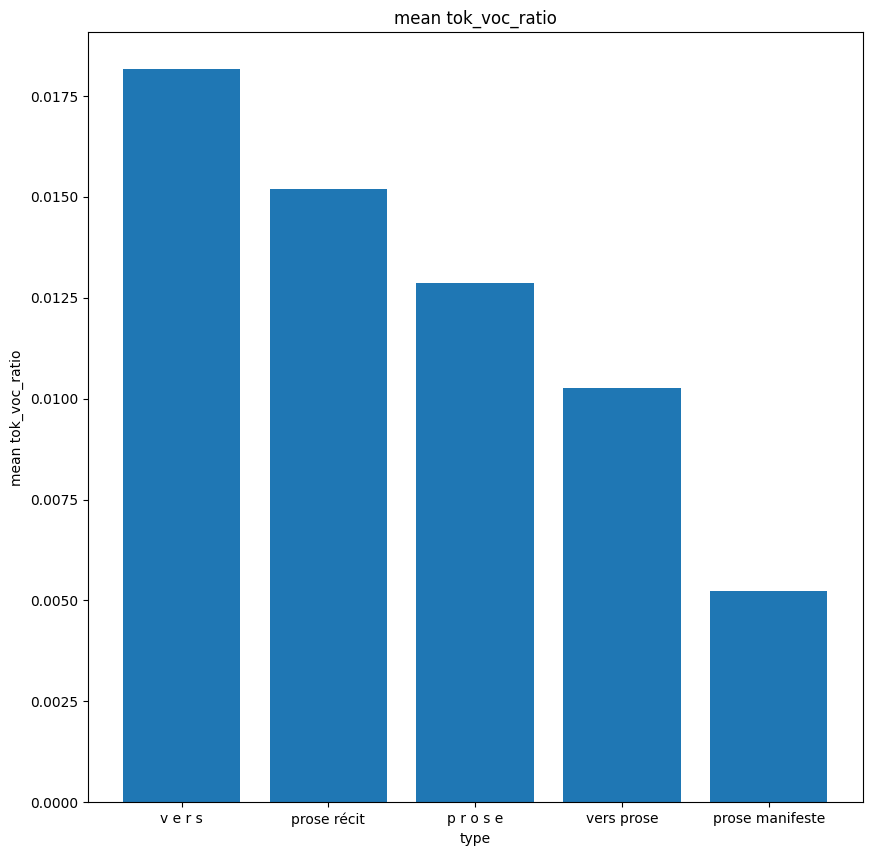

In [72]:
def stats(key):
    stats = {}
    for txt, val in dict_stats.items():
        type_ = val["header"]["form"] if isinstance(val["header"]["form"], str) else tuple(val["header"]["form"])

        if type_ not in stats:
            for e in stats.keys():
                if set(e) == set(type_):
                    type_ = e
                    break
            else:
                stats[type_] = []

        stats[type_].append(mean(val[key]))

    for k, v in stats.items():
        print(f"{k}: {mean(v):.3f}")

    plot = [(" ".join(k), mean(v)) for k, v in stats.items()]
    plot = sorted(plot, key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 10))
    plt.title(f"mean {key}")
    plt.xlabel("type")
    plt.ylabel(f"mean {key}")

    plt.bar(*zip(*plot))

    plt.show()

stats("tok_voc_ratio")

vers: 0.842
prose: 0.871
('vers', 'prose'): 0.868
('prose', 'manifeste'): 0.870
('prose', 'récit'): 0.859


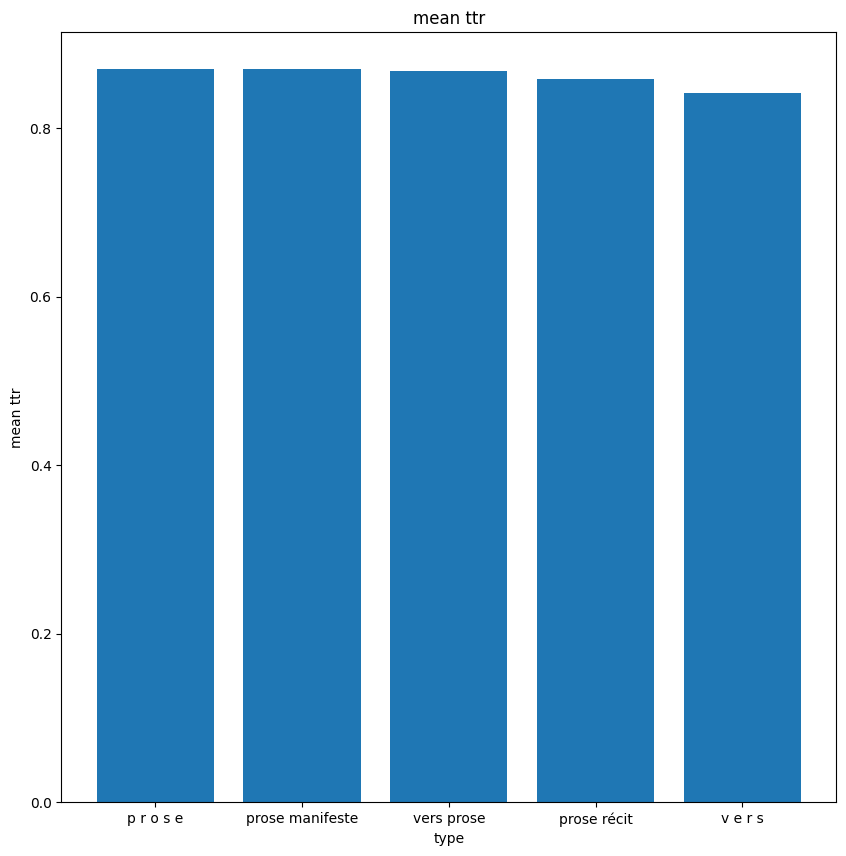

In [73]:
stats("ttr")


vers: 0.002
prose: 0.002
('vers', 'prose'): 0.001
('prose', 'manifeste'): 0.001
('prose', 'récit'): 0.001


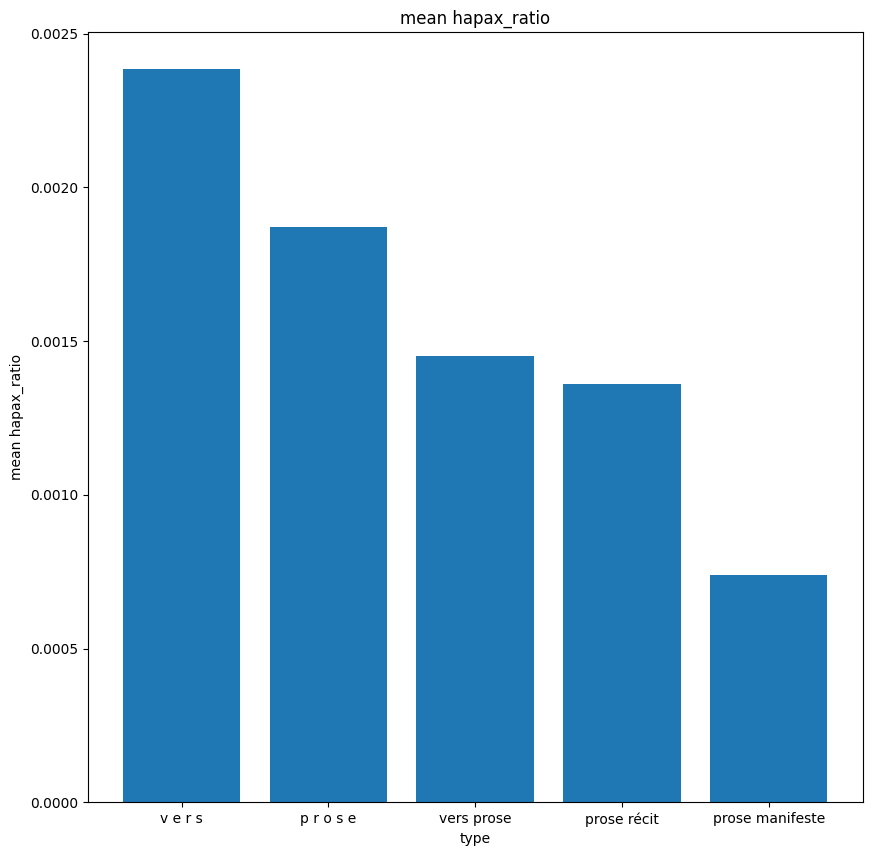

In [74]:
stats("hapax_ratio")

In [81]:
for txt, val in dict_stats.items():
    pprint(val)
    break

{'chars': 4673,
 'hapax': 9,
 'hapax_ratio': 0.00225,
 'header': {'change': {'@status': 'corrected',
                       '@when': '2022-09-06',
                       '@who': 'AB'},
            'creation': '1650-01-18',
            'dates': [{'#text': '16 février 2021',
                       '@type': 'file_creation',
                       '@when': '2021-02-16'},
                      {'#text': '23 avril 2021',
                       '@type': 'correction',
                       '@when': '2021-04-23'}],
            'form': 'vers',
            'genre': ['poésie', 'burlesque', 'satirique'],
            'handwritten_note': False,
            'illustration': False,
            'subject': 'Conti, Armand de Bourbon, prince de, 1629-1666',
            'table_of_content': False,
            'titre': "L'apologie de l'autruche en vers burlesques."},
 'lines': 173,
 'pages': 7,
 'tok_voc_ratio': 0.01675,
 'ttr': 0.84225,
 'ttrs': [0.0,
          0.39669421487603307,
          0.55555555555555